In [6]:
import pandas as pd
import os

os.chdir('D:\Analytics\BloodDonate')
trainfile = 'trainset.csv'
train = pd.read_csv(trainfile)
test = pd.read_csv('testset.csv')

In [22]:
train = train.rename(columns={'Made Donation in March 2007': 'Made_Donation_in_March_2007'})

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [21]:
train.describe().astype(int)


,personId,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
count,576,576,576,576,576,576
mean,374,9,5,1356,34,0
std,216,8,5,1435,24,0
min,0,0,1,250,2,0
25%,183,2,2,500,16,0
50%,375,7,4,1000,28,0
75%,562,14,7,1750,49,0
max,747,74,50,12500,98,1


# Data Exploration

In [29]:
# Total number of records
n_records = train.shape[0]

# Number of records where individual who will give
n_giving = train.Made_Donation_in_March_2007.value_counts()[1].astype(int)

# Number of records where individual who will not give
n_notgiving = train.Made_Donation_in_March_2007.value_counts()[0].astype(int)

# Percentage of individuals who will give
greater_percent = n_giving / n_records

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals giving: {}".format(n_giving)
print "Individuals not giving: {}".format(n_notgiving)
print "Percentage of individuals giving: {:.2f}%".format(n_giving*100 / n_records)

Total number of records: 576
Individuals giving: 138
Individuals not giving: 438
Percentage of individuals giving: 23.00%


# Data Pre-Processing : 
Before we move on to modeling we're going to perform some preprocessing on our dataset to adjust the quality of our variables.

In [34]:
X_train = train[['Months since Last Donation' , 'Number of Donations', 'Total Volume Donated (c.c.)' , 'Months since First Donation']]
y_train = train['Made_Donation_in_March_2007']

D:\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  


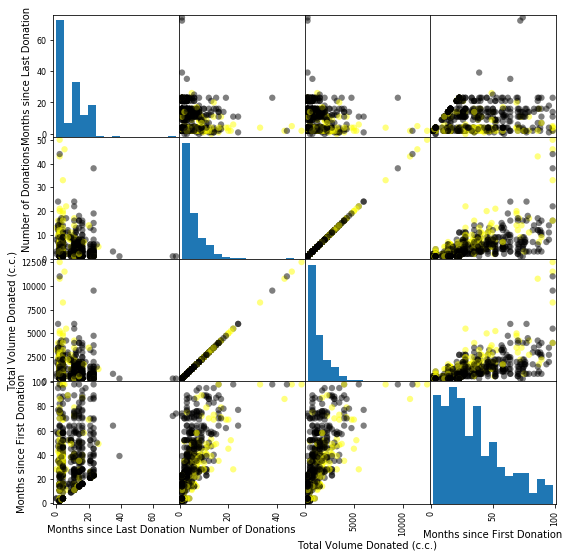

In [19]:
cmap = cm.get_cmap('gnuplot')
scatter = pd.scatter_matrix(X_train, c= y_train, marker = 'o', s=40, hist_kwds={'bins':15}, figsize=(9,9), cmap=cmap)

# Log Transformation
Notice the strong positive skew present in the features. In order to compress the range of our dataset and deal with outliers we will perform a log transformation using np.log().

In [46]:
skewed = ['Months since Last Donation' , 'Number of Donations', 'Total Volume Donated (c.c.)' , 'Months since First Donation']
features_raw = X_train
features_raw[skewed] = train[skewed].apply(lambda x: np.log(x + 1))

D:\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  


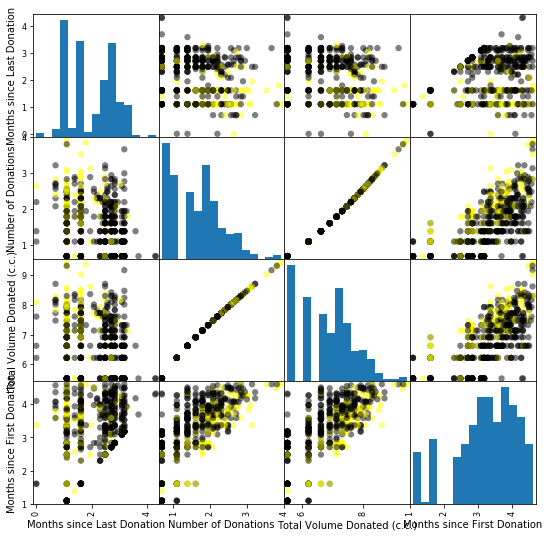

In [38]:
cmap = cm.get_cmap('gnuplot')
scatter = pd.scatter_matrix(X_train, c= y_train, marker = 'o', s=40, hist_kwds={'bins':15}, figsize=(9,9), cmap=cmap)

# Scaling (Normalizing) Numeric Features

After implementing our log transformation, it's good practice to perform scaling on numerical features so that each feature will be weighted equally when we have our algorithm ingest it. 
##### NOTE: once scaling has been applied, the features will not be recognizable.

In [47]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['Months since Last Donation' , 'Number of Donations', 'Total Volume Donated (c.c.)' , 'Months since First Donation']
features_raw[numerical] = scaler.fit_transform(train[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(1))

D:\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation
0,0.027027,1.0,1.0,1.0


# Encoding Categorical Features

Since most machine learning algorithms will expect all features to be numeric, we'll perform feature encoding using pandas pd.get_dummies() function which will transform category values into numeric dummy variables within a dataframe.


In [48]:
features = pd.get_dummies(features_raw)
encoded = list(features.columns)
print "{} total features after encoding.".format(len(encoded))

4 total features after encoding.


# Splitting the dataset for ML algorithm application

In [49]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

donated = y_train
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, donated, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 460 samples.
Testing set has 116 samples.


D:\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [56]:
from sklearn.metrics import accuracy_score, fbeta_score #metrics / scoring
from sklearn.naive_bayes import GaussianNB
from time import time

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test):
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: donated training set
       - X_test: features testing set
       - y_test: donated testing set
    '''

    results = {}

    # Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size]) #sample_weight=sample_size
    end = time() # Get end time

    # Calculate the training time
    results['train_time'] = (end - start)

    # Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test) #pred = clf.predict(features_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time

    # Total prediction time
    results['pred_time'] = (end - start)

    # Compute accuracy on 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)

    # Compute accuracy on test set
    results['acc_test']  = accuracy_score(y_test, predictions_test)


    # Compute F-score on 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=.5)


    # Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=.5)

    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)

    # Return the results
    return results

train_predict(GaussianNB(), 310, X_train, y_train,X_test, y_test)

GaussianNB trained on 310 samples.


{'acc_test': 0.7672413793103449,
 'acc_train': 0.7633333333333333,
 'f_test': 0.6060606060606061,
 'f_train': 0.3902439024390244,
 'pred_time': 0.006000041961669922,
 'train_time': 0.0019998550415039062}

# Model Comparison / Evaluation
Great now that we've estabilished a modeling pipeline, established baseline performance and selecte two other algorithms we can now, finally, get to modeling.

In [140]:
# Import the 5 supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier

#2 creating classifier
# Initialize the 5 models
clf_A = GaussianNB()
clf_B = LogisticRegression(random_state = 0)
clf_C = RandomForestClassifier(random_state = 0)
clf_D = AdaBoostClassifier(random_state=1)
clf_E = SVC(random_state=1)
clf_W = GradientBoostingClassifier(random_state=10)



# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = X_train.shape[0]*0.01; samples_1 = int(samples_1)
samples_10 = X_train.shape[0]*0.1; samples_10 = int(samples_10)
samples_100 = X_train.shape[0]; samples_100 = int(samples_100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C, clf_D, clf_E, clf_W]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

GaussianNB trained on 4 samples.
GaussianNB trained on 46 samples.
GaussianNB trained on 460 samples.
LogisticRegression trained on 4 samples.
LogisticRegression trained on 46 samples.
LogisticRegression trained on 460 samples.
RandomForestClassifier trained on 4 samples.
RandomForestClassifier trained on 46 samples.
RandomForestClassifier trained on 460 samples.
AdaBoostClassifier trained on 4 samples.
AdaBoostClassifier trained on 46 samples.
AdaBoostClassifier trained on 460 samples.
SVC trained on 4 samples.
SVC trained on 46 samples.
SVC trained on 460 samples.
GradientBoostingClassifier trained on 4 samples.
GradientBoostingClassifier trained on 46 samples.
GradientBoostingClassifier trained on 460 samples.


In [141]:
# Printing out the values
for i in results.items():
    print i[0]
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

LogisticRegression


,1%,10%,100%
acc_test,0.293103,0.698276,0.715517
acc_train,0.346667,0.770000,0.773333
f_test,0.307517,0.000000,0.232558
f_train,0.278578,0.000000,0.068493
pred_time,0.000000,0.001000,0.000000
train_time,0.002000,0.001000,0.002000


RandomForestClassifier


,1%,10%,100%
acc_test,0.612069,0.706897,0.732759
acc_train,0.560000,0.766667,0.936667
f_test,0.267176,0.272727,0.521739
f_train,0.103896,0.190476,0.904437
pred_time,0.003000,0.003000,0.003000
train_time,0.039000,0.032000,0.035000


GaussianNB


,1%,10%,100%
acc_test,0.284483,0.724138,0.750000
acc_train,0.310000,0.740000,0.760000
f_test,0.304740,0.495495,0.542169
f_train,0.250723,0.298507,0.325444
pred_time,0.002000,0.000000,0.001000
train_time,0.002000,0.002000,0.001000


AdaBoostClassifier


,1%,10%,100%
acc_test,0.603448,0.732759,0.706897
acc_train,0.493333,0.756667,0.810000
f_test,0.386473,0.392157,0.421053
f_train,0.136452,0.170940,0.565611
pred_time,0.014000,0.013000,0.014000
train_time,0.151000,0.136000,0.154000


SVC


,1%,10%,100%
acc_test,0.568966,0.698276,0.698276
acc_train,0.603333,0.770000,0.770000
f_test,0.314136,0.000000,0.000000
f_train,0.192802,0.000000,0.000000
pred_time,0.001000,0.001000,0.004000
train_time,0.001000,0.001000,0.006000


GradientBoostingClassifier


,1%,10%,100%
acc_test,0.603448,0.698276,0.732759
acc_train,0.493333,0.763333,0.860000
f_test,0.386473,0.298507,0.514019
f_train,0.136452,0.213675,0.722892
pred_time,0.001000,0.002000,0.001000
train_time,0.031000,0.049000,0.082000


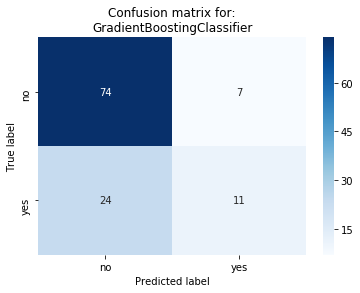

In [142]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix for a model
model = clf_W
cm = confusion_matrix(y_test.values, model.predict(X_test))

# view with a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for:\n{}'.format(model.__class__.__name__));


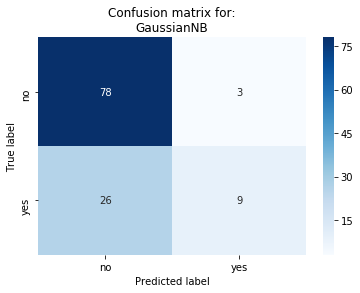

In [82]:
model = clf_A
cm = confusion_matrix(y_test.values, model.predict(X_test))

# view with a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for:\n{}'.format(model.__class__.__name__));

# Tuning Hyperparameters

In [92]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import accuracy_score, fbeta_score, make_scorer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.grid_search import GridSearchCV

# Initialize the classifier for Random Forest

clf = clf_C

# Create the parameters list you wish to tune
parameters = { 
           "n_estimators" : [9, 18, 27, 36, 45, 54, 63],
           "max_depth" : [1, 5, 10, 15, 20, 25, 30],
           "min_samples_leaf" : [1, 2, 4, 6, 8, 10]}

# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=.5)


# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj =  GridSearchCV(clf,parameters ,scoring=scorer)


# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)


# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.7328
F-score on testing data: 0.5217

Optimized Model
------
Final accuracy score on the testing data: 0.7500
Final F-score on the testing data: 0.5652


#  Feature Importance
Here we'll choose a different scikit-learn supervised learning algorithm that has a feature_importance_ attribute. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm so we can gain an understanding of the underlying importance for each feature within our model. 

# Feature Selection
How does the model perform if we only use a subset of all the available features in the data? With less features required to train, the time requird for training and prediction time is much lower — at the cost of performance metrics.

In [93]:
importances = clf_D.feature_importances_

In [94]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta =.5))

Final Model trained on full data
------
Accuracy on testing data: 0.7500
F-score on testing data: 0.5652

Final Model trained on reduced data
------
Accuracy on testing data: 0.7328
F-score on testing data: 0.5051


###### By performing the reduction we'd expect our model training and prediction times to decrease. If the goal of our model is to produce the most accurate results we'd likely want to move forward with the full model, in contrast if the goal is to create an more parsimonious model we'd favor the smaller, more-lightweight model.

# Testing on the test file

In [117]:
clf_test = SVC(random_state=1, probability=True)
clf_test = clf_test.fit(X_train[:int(X_train.shape[0])], y_train[:int(X_train.shape[0])]) #sample_weight=sample_size
predictions_test_file = best_clf.predict_proba(features_raw_test[['Months since Last Donation' , 'Number of Donations', 'Total Volume Donated (c.c.)' , 'Months since First Donation']])

In [143]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
features_raw_test = test[['Months since Last Donation' , 'Number of Donations', 'Total Volume Donated (c.c.)' , 'Months since First Donation']]
numerical = ['Months since Last Donation' , 'Number of Donations', 'Total Volume Donated (c.c.)' , 'Months since First Donation']
features_raw_test[numerical] = scaler.fit_transform(test[numerical])

# Show an example of a record with scaling applied
display(features_raw_test.head(2))

D:\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation
0,0.050,0.275,0.275,0.520833
1,0.525,0.150,0.150,0.375000


In [138]:
predictions_test_file = clf_W.predict_proba(features_raw_test)

In [139]:
predictions_test_file

array([[0.79244194, 0.20755806],
       [0.09863767, 0.90136233],
       [0.94967273, 0.05032727],
       [0.85713306, 0.14286694],
       [0.47802267, 0.52197733],
       [0.07291959, 0.92708041],
       [0.73417727, 0.26582273],
       [0.95073349, 0.04926651],
       [0.36534037, 0.63465963],
       [0.57986584, 0.42013416],
       [0.94797434, 0.05202566],
       [0.93326043, 0.06673957],
       [0.92945891, 0.07054109],
       [0.94967273, 0.05032727],
       [0.49815811, 0.50184189],
       [0.9343651 , 0.0656349 ],
       [0.81769916, 0.18230084],
       [0.68482949, 0.31517051],
       [0.26393196, 0.73606804],
       [0.53307271, 0.46692729],
       [0.26987711, 0.73012289],
       [0.35098233, 0.64901767],
       [0.78685543, 0.21314457],
       [0.94967273, 0.05032727],
       [0.73776587, 0.26223413],
       [0.95093759, 0.04906241],
       [0.72629873, 0.27370127],
       [0.95073349, 0.04926651],
       [0.80985521, 0.19014479],
       [0.79244194, 0.20755806],
       [0.